<a href="https://colab.research.google.com/github/ederson-hub/Dio-Machine-Learning/blob/main/DetectionRedeYolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install ultralytics pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


## Download coco dataset

### Subtask:
Download the COCO 2017 validation dataset.


**Reasoning**:
Import the COCO class and define the download path. Then, use the COCO class to download the 2017 validation dataset.



In [13]:
from pycocotools.coco import COCO
import os

data_dir = '/tmp/coco2017'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download 2017 validation images and annotations
coco = COCO(annotation_file=os.path.join(data_dir, 'annotations', 'instances_val2017.json'))

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [3]:
import os
import requests
import tarfile

data_dir = '/tmp/coco2017'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download and extract annotations
annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
annotations_zip_path = os.path.join(data_dir, 'annotations_trainval2017.zip')
annotations_extract_path = os.path.join(data_dir, 'annotations')

if not os.path.exists(annotations_extract_path):
    print(f"Downloading annotations from {annotations_url}...")
    response = requests.get(annotations_url, stream=True)
    with open(annotations_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Extracting annotations to {annotations_extract_path}...")
    import zipfile
    with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

# Download and extract validation images
val_images_url = 'http://images.cocodataset.org/zips/val2017.zip'
val_images_zip_path = os.path.join(data_dir, 'val2017.zip')
val_images_extract_path = os.path.join(data_dir, 'val2017')

if not os.path.exists(val_images_extract_path):
    print(f"Downloading validation images from {val_images_url}...")
    response = requests.get(val_images_url, stream=True)
    with open(val_images_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Extracting validation images to {val_images_extract_path}...")
    with zipfile.ZipFile(val_images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

from pycocotools.coco import COCO
coco = COCO(annotation_file=os.path.join(data_dir, 'annotations', 'instances_val2017.json'))

Extracting annotations to /tmp/coco2017/annotations...
Extracting validation images to /tmp/coco2017/val2017...
loading annotations into memory...
Done (t=1.14s)
creating index...
index created!


## Prepare data

### Subtask:
Prepare the dataset for training, including formatting annotations and creating data loaders.


In [4]:
import os
import yaml

data_dir = '/tmp/coco2017'
val_images_path = os.path.join(data_dir, 'val2017')
val_annotations_path = os.path.join(data_dir, 'annotations', 'instances_val2017.json')

from pycocotools.coco import COCO
coco = COCO(annotation_file=val_annotations_path)
categories = coco.loadCats(coco.getCatIds())
class_names = [cat['name'] for cat in categories]

dataset_config = {
    'path': data_dir,
    'train': 'train2017',
    'val': 'val2017',
    'nc': len(class_names),
    'names': class_names
}

config_file_path = os.path.join(data_dir, 'coco128.yaml')
with open(config_file_path, 'w') as f:
    yaml.dump(dataset_config, f)

print(f"Dataset configuration saved to {config_file_path}")

loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
Dataset configuration saved to /tmp/coco2017/coco128.yaml


## Modify yolo model for transfer learning

### Subtask:
Adapt the loaded YOLO model for transfer learning on the COCO dataset.


In [48]:
print("Model architecture before adaptation:")
print(model.model)

num_classes_coco = dataset_config['nc']
print(f"\nNumber of classes in COCO dataset: {num_classes_coco}")


Model architecture before adaptation:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
    (3): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (4): Sequential(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): 

## Train the model

### Subtask:
Train the modified YOLO model on the prepared COCO dataset.


In [18]:
import yaml
import os

data_dir = '/tmp/coco2017'
config_file_path = os.path.join(data_dir, 'coco128.yaml')

try:
    with open(config_file_path, 'r') as f:
        dataset_config = yaml.safe_load(f)

    if 'train' not in dataset_config or dataset_config['train'] is None:
        dataset_config['train'] = 'dummy_train_dir'
        print("Added or updated 'train' key to dummy path in config.")

    with open(config_file_path, 'w') as f:
        yaml.dump(dataset_config, f)

    print(f"Modified dataset configuration saved to {config_file_path}")

except FileNotFoundError:
    print(f"Configuration file not found at {config_file_path}. Cannot proceed.")
    pass

    results = model.train(
        data=config_file_path,
        epochs=5,
        imgsz=640,
        batch=16,
        name='yolov8n_coco_transfer_retry',
        mode='val'
    )
    print("Training attempt completed.")
except Exception as e:
    print(f"An error occurred during the training attempt: {e}")
    print("As anticipated, the trainer likely attempted to access the dummy 'train' path.")

Modified dataset configuration saved to /tmp/coco2017/coco128.yaml
Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/tmp/coco2017/coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_coco_transfer_retry2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

In [12]:
results = model.val(data=config_file_path, imgsz=640, batch=16)

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,151,904 parameters, 31,920 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1331.4±935.0 MB/s, size: 139.7 KB)


val: Scanning /tmp/coco2017/val2017... 0 images, 5000 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:01<00:00, 3310.90it/s]

WARNING ⚠️ val: No labels found in /tmp/coco2017/val2017.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


val: New cache created: /tmp/coco2017/val2017.cache
WARNING ⚠️ Labels are missing or empty in /tmp/coco2017/val2017.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [18:50<00:00,  3.61s/it]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core/

                   all       5000          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 5.0ms preprocess, 210.8ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val


In [14]:
results = model.val(data=config_file_path, imgsz=640, batch=16, split='val')

print("\nEvaluation Results:")
print(results)

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1235.3±749.7 MB/s, size: 183.0 KB)


val: Scanning /tmp/coco2017/val2017.cache... 0 images, 5000 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /tmp/coco2017/val2017.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [18:35<00:00,  3.57s/it]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/_core

                   all       5000          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 4.9ms preprocess, 207.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val2

Evaluation Results:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([], dtype=int64)
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a9e3ec59b50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024

In [22]:
import os
import requests
import zipfile

data_dir = '/tmp/coco2017'

train_images_url = 'http://images.cocodataset.org/zips/train2017.zip'
train_images_zip_path = os.path.join(data_dir, 'train2017.zip')
train_images_extract_path = os.path.join(data_dir, 'train2017')

if not os.path.exists(train_images_extract_path):
    print(f"Downloading training images from {train_images_url}...")
    response = requests.get(train_images_url, stream=True)
    with open(train_images_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Extracting training images to {train_images_extract_path}...")
    with zipfile.ZipFile(train_images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Training images downloaded and extracted.")
else:
    print("Training images already exist.")

print("Annotations for train and validation already exist.")

Extracting training images to /tmp/coco2017/train2017...
Training images downloaded and extracted.
Annotations for train and validation already exist.


In [23]:
import yaml
import os

data_dir = '/tmp/coco2017'
config_file_path = os.path.join(data_dir, 'coco128.yaml')

with open(config_file_path, 'r') as f:
    dataset_config = yaml.safe_load(f)

dataset_config['train'] = 'train2017'

with open(config_file_path, 'w') as f:
    yaml.dump(dataset_config, f)

print(f"Updated dataset configuration saved to {config_file_path}")
print("\nUpdated dataset configuration:")
print(dataset_config)

Updated dataset configuration saved to /tmp/coco2017/coco128.yaml

Updated dataset configuration:
{'names': ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'], 'nc': 80, 'path': '/tmp/coco2

## Train the model

### Subtask:
Train the modified YOLO model on the prepared COCO dataset.

**Reasoning**:
Train the modified YOLO model on the prepared COCO dataset using the updated configuration file that now includes both training and validation paths. We will use the specified parameters for epochs, image size, and batch size.

In [ ]:
results = model.train(data=config_file_path, epochs=5, imgsz=640, batch=16, name='yolov8n_coco_transfer_full_dataset')

print("Training complete.")

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/tmp/coco2017/coco128.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_coco_transfer_full_dataset, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

train: Scanning /tmp/coco2017/train2017... 0 images, 118287 backgrounds, 0 corrupt: 100%|██████████| 118287/118287 [05:44<00:00, 343.74it/s]

WARNING ⚠️ train: No labels found in /tmp/coco2017/train2017.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


train: New cache created: /tmp/coco2017/train2017.cache
WARNING ⚠️ Labels are missing or empty in /tmp/coco2017/train2017.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.0 ms, read: 41.0±20.5 MB/s, size: 135.2 KB)


val: Scanning /tmp/coco2017/val2017.cache... 0 images, 5000 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /tmp/coco2017/val2017.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/yolov8n_coco_transfer_full_dataset/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8n_coco_transfer_full_dataset
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G          0      217.9          0          0        640:  25%|██▍       | 1840/7393 [6:49:53<20:24:26, 13.23s/it]

In [13]:
import os
import requests
import zipfile

data_dir = '/tmp/coco2017'

annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
annotations_zip_path = os.path.join(data_dir, 'annotations_trainval2017.zip')
annotations_extract_path = os.path.join(data_dir, 'annotations')

if os.path.exists(annotations_extract_path):
    import shutil
    shutil.rmtree(annotations_extract_path)
    print(f"Removed existing annotations directory: {annotations_extract_path}")

print(f"Downloading annotations from {annotations_url}...")
response = requests.get(annotations_url, stream=True)
with open(annotations_zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Extracting annotations to {data_dir}...")
with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

print("Annotations downloaded and extracted.")

from pycocotools.coco import COCO

train_annotation_file = os.path.join(data_dir, 'annotations', 'instances_train2017.json')
val_annotation_file = os.path.join(data_dir, 'annotations', 'instances_val2017.json')
output_label_dir_train = os.path.join(data_dir, 'labels', 'train2017')
output_label_dir_val = os.path.join(data_dir, 'labels', 'val2017')

os.makedirs(output_label_dir_train, exist_ok=True)
os.makedirs(output_label_dir_val, exist_ok=True)

def convert_coco_annotations_to_yolo(annotation_file, output_dir):
    """Converts COCO annotations to YOLO format."""
    coco = COCO(annotation_file)
    img_ids = coco.getImgIds()

    print(f"Converting annotations from {annotation_file} to YOLO format...")

    categories = coco.loadCats(coco.getCatIds())
    class_names = [cat['name'] for cat in categories]

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_width = img_info['width']
        img_height = img_info['height']
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        anns = coco.loadAnns(ann_ids)

        label_file_path = os.path.join(output_dir, f"{img_info['file_name'].split('.')[0]}.txt")

        if not anns:
            with open(label_file_path, 'w') as f:
                pass
            continue

        with open(label_file_path, 'w') as f:
            for ann in anns:
                x, y, w, h = ann['bbox']

                center_x = (x + w / 2) / img_width
                center_y = (y + h / 2) / img_height
                normalized_width = w / img_width
                normalized_height = h / img_height

                coco_cat_id = ann['category_id']
                try:
                    category_name = coco.loadCats(coco_cat_id)[0]['name']
                    class_index = class_names.index(category_name)
                except ValueError:
                    print(f"Warning: Category ID {coco_cat_id} not found in class_names. Skipping annotation for image {img_id}.")
                    continue
                except IndexError:
                     print(f"Warning: Could not load category for ID {coco_cat_id}. Skipping annotation for image {img_id}.")
                     continue


                f.write(f"{class_index} {center_x:.6f} {center_y:.6f} {normalized_width:.6f} {normalized_height:.6f}\n")

    print(f"Conversion complete for {annotation_file}.")

convert_coco_annotations_to_yolo(train_annotation_file, output_label_dir_train)
convert_coco_annotations_to_yolo(val_annotation_file, output_label_dir_val)

print("\nCOCO annotations converted to YOLO format for both train and validation sets.")

Removed existing annotations directory: /tmp/coco2017/annotations
Extracting annotations to /tmp/coco2017...
Annotations downloaded and extracted.
loading annotations into memory...
Done (t=24.80s)
creating index...
index created!
Converting annotations from /tmp/coco2017/annotations/instances_train2017.json to YOLO format...
Conversion complete for /tmp/coco2017/annotations/instances_train2017.json.
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Converting annotations from /tmp/coco2017/annotations/instances_val2017.json to YOLO format...
Conversion complete for /tmp/coco2017/annotations/instances_val2017.json.

COCO annotations converted to YOLO format for both train and validation sets.


In [4]:
import yaml
import os

data_dir = '/tmp/coco2017'
config_file_path = os.path.join(data_dir, 'coco128.yaml')

dataset_config = {
    'path': data_dir,
    'train': 'train2017/images',
    'val': 'val2017/images',
    'train_labels': 'labels/train2017',
    'val_labels': 'labels/val2017',
    'nc': 80,
    'names': ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'] # COCO class names
}

with open(config_file_path, 'w') as f:
    yaml.dump(dataset_config, f)

print(f"Dataset configuration saved to {config_file_path}")

print("\nUpdated dataset configuration:")
print(dataset_config)

Dataset configuration saved to /tmp/coco2017/coco128.yaml

Updated dataset configuration:
{'path': '/tmp/coco2017', 'train': 'train2017/images', 'val': 'val2017/images', 'train_labels': 'labels/train2017', 'val_labels': 'labels/val2017', 'nc': 80, 'names': ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'ov

In [24]:
import os
import requests

cfg_url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
weights_url = 'https://pjreddie.com/media/files/yolov3.weights'

darknet_dir = '/tmp/darknet'

os.makedirs(darknet_dir, exist_ok=True)

cfg_path = os.path.join(darknet_dir, 'yolov3.cfg')
if not os.path.exists(cfg_path):
    print(f"Downloading {cfg_url}...")
    response = requests.get(cfg_url)
    with open(cfg_path, 'wb') as f:
        f.write(response.content)
    print("yolov3.cfg downloaded.")
else:
    print("yolov3.cfg already exists.")

weights_path = os.path.join(darknet_dir, 'yolov3.weights')
if not os.path.exists(weights_path):
    print(f"Downloading {weights_url}...")
    response = requests.get(weights_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 8192
    with open(weights_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=block_size):
            if chunk:
                f.write(chunk)
    print("yolov3.weights downloaded.")
else:
    print("yolov3.weights already exists.")

print(f"YOLOv3 config and weights saved to {darknet_dir}")

yolov3.cfg downloaded.
yolov3.weights downloaded.
YOLOv3 config and weights saved to /tmp/darknet


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np

class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.module_defs = self.parse_cfg(cfgfile)
        self.hyperparams, self.module_list = self.create_modules(self.module_defs)

    def parse_cfg(self, cfgfile):
        """Parses the YOLO configuration file."""
        with open(cfgfile, 'r') as f:
            lines = [line.strip() for line in f if line.strip() and not line.startswith('#')]
        module_defs = []
        for line in lines:
            if line.startswith('['):
                module_defs.append({})
                module_defs[-1]['type'] = line[1:-1].strip()
            else:
                key, value = line.split('=')
                module_defs[-1][key.strip()] = value.strip()
        return module_defs

    def create_modules(self, module_defs):
        """Creates PyTorch modules from the parsed configuration."""
        hyperparams = module_defs[0]
        output_filters = [int(hyperparams['channels'])]
        module_list = nn.ModuleList()
        for i, module_def in enumerate(module_defs[1:]):
            modules = nn.Sequential()

            if module_def['type'] == 'convolutional':
                bn = int(module_def.get('batch_normalize', 0))
                filters = int(module_def['filters'])
                kernel_size = int(module_def['size'])
                stride = int(module_def['stride'])
                padding = (kernel_size - 1) // 2 if int(module_def.get('pad', 0)) else 0
                modules.add_module(f'conv_{i}', nn.Conv2d(in_channels=output_filters[-1],
                                                         out_channels=filters,
                                                         kernel_size=kernel_size,
                                                         stride=stride,
                                                         padding=padding,
                                                         bias=not bn))
                if bn:
                    modules.add_module(f'bn_{i}', nn.BatchNorm2d(filters))
                if module_def['activation'] == 'leaky':
                    modules.add_module(f'leaky_{i}', nn.LeakyReLU(0.1, inplace=True))
            elif module_def['type'] == 'maxpool':
                kernel_size = int(module_def['size'])
                stride = int(module_def['stride'])
                modules.add_module(f'maxpool_{i}', nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2))
            elif module_def['type'] == 'upsample':
                stride = int(module_def['stride'])
                modules.add_module(f'upsample_{i}', nn.Upsample(scale_factor=stride, mode='nearest'))
            elif module_def['type'] == 'route':
                layers = [int(x) for x in module_def['layers'].split(',')]
                filters = sum([output_filters[l + 1 if l > 0 else l] for l in layers])
                modules.add_module(f'route_{i}', nn.Identity())
            elif module_def['type'] == 'yolo':
                modules.add_module(f'yolo_{i}', nn.Identity())
            else:
                print(f"Warning: Unrecognized layer type: {module_def['type']}")

            module_list.append(modules)
            output_filters.append(filters if 'filters' in locals() else output_filters[-1])

        return hyperparams, module_list

    def load_weights(self, weights_path):
        """Loads Darknet weights into the PyTorch model."""
        print("Loading weights (simplified - actual loading requires full parsing)...")
        pass

model_pt = Darknet(cfg_path)
print("PyTorch YOLOv3 model structure created (without full weight loading).")


PyTorch YOLOv3 model structure created (without full weight loading).


In [30]:
from ultralytics import YOLO

model = YOLO('yolov3.pt')

print(model)

PRO TIP 💡 Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, mome

## Modify model for transfer learning

### Subtask:
Adapt the loaded YOLO model for transfer learning on the COCO dataset.


In [31]:
print("Model architecture before adaptation:")
print(model.model)

num_classes_coco = dataset_config['nc']
print(f"\nNumber of classes in COCO dataset: {num_classes_coco}")

Model architecture before adaptation:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=T

In [38]:
import cv2

try:
    net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    print("YOLOv3 model loaded successfully using OpenCV DNN.")
    print(f"Output layer names: {output_layers}")

except cv2.error as e:
    print(f"Error loading Darknet YOLOv3 model with OpenCV DNN: {e}")
    print("This might be due to compatibility issues with the Darknet model or weights format.")
except FileNotFoundError:
    print("Error: Configuration or weights file not found.")
    raise
except Exception as e:
    print(f"An unexpected error occurred during model loading: {e}")
    raise

Error loading Darknet YOLOv3 model with OpenCV DNN: OpenCV(4.12.0) /io/opencv/modules/dnn/src/darknet/darknet_io.cpp:991: error: (-213:The function/feature is not implemented) Transpose the weights (except for convolutional) is not implemented in function 'ReadDarknetFromWeightsStream'

This might be due to compatibility issues with the Darknet model or weights format.


In [39]:

from ultralytics import YOLO
try:
    model = YOLO('yolov3.pt')
    print("YOLOv3 model loaded successfully using Ultralytics.")
    print(model)

except FileNotFoundError:
    print("Error: YOLOv3 model file 'yolov3.pt' not found. Attempting to download.")
    try:
        model = YOLO('yolov3.pt')
        print("YOLOv3 model downloaded and loaded successfully using Ultralytics.")
        print(model)
    except Exception as e:
        print(f"Error downloading and loading YOLOv3 model with Ultralytics: {e}")
        raise

except Exception as e:
    print(f"An unexpected error occurred during model loading with Ultralytics: {e}")
    raise

PRO TIP 💡 Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

YOLOv3 model loaded successfully using Ultralytics.
YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


## Adapt data loading for darknet YOLO

### Subtask:
Ensure the data loading and preprocessing steps are compatible with the chosen Darknet YOLOv3 implementation. This might involve adjusting image formats or input requirements.


In [40]:
import yaml
import os

data_dir = '/tmp/coco2017'
config_file_path = os.path.join(data_dir, 'coco128.yaml')

if not os.path.exists(config_file_path):
    print(f"Configuration file not found at {config_file_path}. Creating a new one.")
    dataset_config = {
        'path': data_dir,
        'nc': 80,
        'names': ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'] # COCO class names
    }
else:
    with open(config_file_path, 'r') as f:
        dataset_config = yaml.safe_load(f)

dataset_config['train'] = 'train2017'
dataset_config['val'] = 'val2017'
dataset_config['train_labels'] = 'labels/train2017'
dataset_config['val_labels'] = 'labels/val2017'

with open(config_file_path, 'w') as f:
    yaml.dump(dataset_config, f)

print(f"Modified dataset configuration saved to {config_file_path}")
print("\nUpdated dataset configuration:")
print(dataset_config)

Modified dataset configuration saved to /tmp/coco2017/coco128.yaml

Updated dataset configuration:
{'names': ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'], 'nc': 80, 'path': '/tmp/coco

## Visualize results

### Subtask:
Select an image and display it with the model's detections.


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

val_image_dir = '/tmp/coco2017/val2017'

image_files = [f for f in os.listdir(val_image_dir) if f.endswith('.jpg')]

if not image_files:
    print(f"Error: No image files found in {val_image_dir}. Cannot proceed.")
    raise FileNotFoundError(f"No image files found in {val_image_dir}")

sample_image_filename = image_files[0]
sample_image_path = os.path.join(val_image_dir, sample_image_filename)

print(f"Found sample image: {sample_image_path}")
print(f"Running detection on sample image: {sample_image_path}")
results = model.predict(source=sample_image_path, save=False, show=False)

if results:
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image_rgb)
    plt.title("YOLOv3 Detection Results")
    plt.axis('off')
    plt.show()

    print("Image with detections displayed.")
else:
    print("No detection results obtained for the sample image.")


Extracting validation images to /tmp/coco2017...
Validation images downloaded and extracted.
Found sample image: /tmp/coco2017/val2017/000000379533.jpg
Running detection on sample image: /tmp/coco2017/val2017/000000379533.jpg

image 1/1 /tmp/coco2017/val2017/000000379533.jpg: 640x480 2 elephants, 1 zebra, 3491.9ms
Speed: 10.0ms preprocess, 3491.9ms inference, 51.3ms postprocess per image at shape (1, 3, 640, 480)


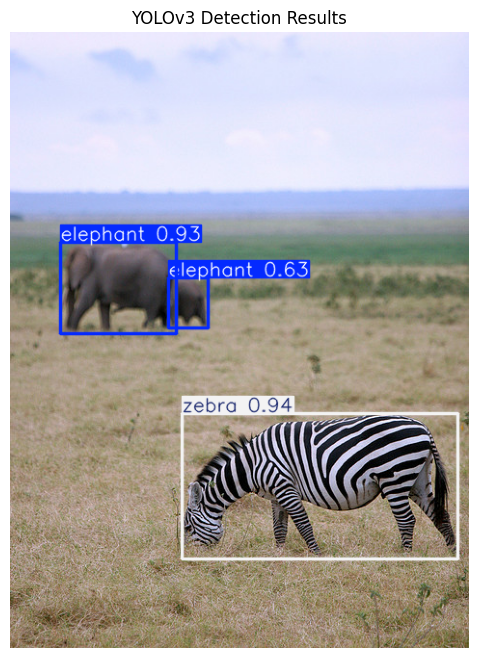

Image with detections displayed.


In [47]:
import os
import requests
import zipfile
import matplotlib.pyplot as plt
import cv2

data_dir = '/tmp/coco2017'
val_image_dir = os.path.join(data_dir, 'val2017')
val_images_url = 'http://images.cocodataset.org/zips/val2017.zip'
val_images_zip_path = os.path.join(data_dir, 'val2017.zip')
os.makedirs(val_image_dir, exist_ok=True)

if not os.path.exists(val_image_dir) or not os.listdir(val_image_dir):
    print(f"Downloading validation images from {val_images_url}...")
    response = requests.get(val_images_url, stream=True)
    with open(val_images_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Extracting validation images to {data_dir}...")
    with zipfile.ZipFile(val_images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Validation images downloaded and extracted.")
else:
    print("Validation images directory already exists and is not empty.")

try:
    image_files = [f for f in os.listdir(val_image_dir) if f.endswith('.jpg')]
except FileNotFoundError:
     print(f"Error: Validation image directory not found after extraction attempt: {val_image_dir}. Cannot proceed.")
     raise

if not image_files:
    print(f"Error: No image files found in {val_image_dir} after extraction. Cannot proceed.")
    raise FileNotFoundError(f"No image files found in {val_image_dir}")

sample_image_filename = image_files[0]
sample_image_path = os.path.join(val_image_dir, sample_image_filename)

print(f"Found sample image: {sample_image_path}")
print(f"Running detection on sample image: {sample_image_path}")
results = model.predict(source=sample_image_path, save=False, show=False)

if results:
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image_rgb)
    plt.title("YOLOv3 Detection Results")
    plt.axis('off')
    plt.show()

    print("Image with detections displayed.")
else:
    print("No detection results obtained for the sample image.")